In [ ]:
!pip3 install numpy pandas matplotlib seaborn scikit-learn datetime nbformat

In [1]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import math

from sklearn.linear_model import LinearRegression

from datetime import datetime, timedelta

import sqlite3
from airflow import DAG
from airflow.utils.dates import days_ago
from airflow.operators.python_operator import PythonOperator

import nbformat

import warnings
warnings.filterwarnings('ignore')

# Create a requirements.txt file with the necessary packages
!pip freeze > airflow/dags/requirements.txt

/var/folders/3g/lt92y6v536s5sxynst_qrtsm0000gn/T/ipykernel_41928/2620577813.py:17 DeprecationWarning: The `airflow.operators.python_operator.PythonOperator` class is deprecated. Please use `'airflow.operators.python.PythonOperator'`.

## Data Cleaning and Preprocessing

In [2]:
!pwd

/Users/iffiness/Documents/Python Projects/Data Enginnering Projects/Data-Engineering


In [3]:
# =========================== Random Musings =========================== #
spanish_squads = ['Sevilla', 'Sporting Huelva', 'Athletic Club', 'Levante Planas',
       'UDG Tenerife', 'Villarreal', 'Madrid CFF', 'Barcelona',
       'Atlético Madrid', 'Real Madrid', 'Alhama', 'Alavés',
       'Real Sociedad', 'Levante', 'Real Betis', 'Valencia']

explanable_cols = ['Player','Nation','Pos','Squad','Age','Born','Starts','Min','Gls','Total_Att','Blocks_Blocks','Blocks_Sh','Blocks_Pass','Clr','Err','Touches_Touches','Touches_DefPen','Dribbles_Succ','Dribbles_Att','Dribbles_Mis','AerialDuels_Won','AerialDuels_Lost']

In [4]:
# DAG arguments
default_args = {
    'owner': 'Lagom-QB',
    'depends_on_past': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5)
}

dag = DAG(
    'ETL_DAG',
    description='Load data into SQLite database using Airflow',
    default_args=default_args,
    schedule_interval=None,
    start_date=days_ago(1),
    catchup=False
)


In [5]:
# Extract  data
file_loc       = 'airflow/dags/assets/matches-checkpoint.csv'
useless_ids    = ['Away_id','Home_id','Match_id','League_id']
spanish_squads = ['Sevilla', 'Sporting Huelva', 'Athletic Club', 'Levante Planas',
                  'UDG Tenerife', 'Villarreal', 'Madrid CFF', 'Barcelona',
                  'Atlético Madrid', 'Real Madrid', 'Alhama', 'Alavés',
                  'Real Sociedad', 'Levante', 'Real Betis', 'Valencia']
def extract_data(file_location = file_loc, spanish_squads = spanish_squads, useless_ids = useless_ids):
    matches = pd.read_csv(file_location)
    # Make sure 'Home' or 'Away' is in the spanish_squads
    matches = matches[(matches['Home'].isin(spanish_squads)) | (matches['Away'].isin(spanish_squads))]
    matches = matches.drop(useless_ids, axis=1).reset_index(drop=True)
    matches['Date'] = pd.to_datetime(matches['Date'])
    
    return matches


matches = extract_data()
display(matches.sample(5), matches.shape, matches.columns.str.lower(), matches.Day.unique())

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
39,7,Sat,2022-10-29,11:45,Athletic Club,0.9,1–4,1.9,Atlético Madrid,0.74,2.04,1,4
2,2,Sat,2022-09-17,16:00,Real Sociedad,0.7,2–0,0.3,Villarreal,1.68,0.87,2,0
42,7,Sat,2022-10-29,18:15,Alhama,1.0,0–2,1.3,Real Betis,1.15,1.57,0,2
35,6,Sun,2022-10-23,11:00,UDG Tenerife,1.3,2–0,0.6,Villarreal,1.90,0.81,2,0
19,4,Sun,2022-10-02,12:00,Levante Planas,2.7,3–1,1.6,Alhama,2.01,0.81,3,1


(87, 13)

Index(['wk', 'day', 'date', 'time', 'home', 'xghome', 'score', 'xgaway',
       'away', 'xphome', 'xpaway', 'scorehome', 'scoreaway'],
      dtype='object')

array(['Sat', 'Sun', 'Tue', 'Wed', 'Thu'], dtype=object)

In [6]:
# Thing is there is nothing like a .2 or .5 of a game, so we need to round up the Scores
def round_scores(matches):
    matches['ScoreHome'] = matches['ScoreHome'].apply(lambda x: math.ceil(x))
    matches['ScoreAway'] = matches['ScoreAway'].apply(lambda x: math.ceil(x))
    
    return matches
matches = round_scores(matches)
display(matches.sample(3))

,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
30,5,Sun,2022-10-16,18:00,Madrid CFF,2.1,4–0,0.2,Real Betis,2.62,0.23,4,0
21,4,Sun,2022-10-02,16:00,Sevilla,1.7,2–2,1.3,Real Sociedad,1.64,1.12,2,2
71,10,Sat,2022-11-26,12:00,Levante,2.2,5–1,1.3,Sevilla,1.93,0.86,5,1


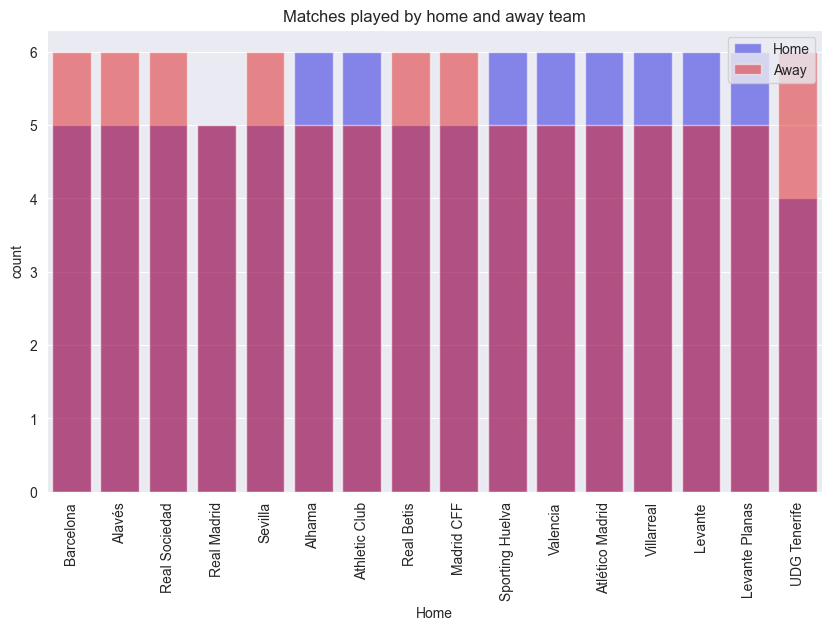

[2023-11-01T23:34:19.266+0100] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-11-01T23:34:19.290+0100] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


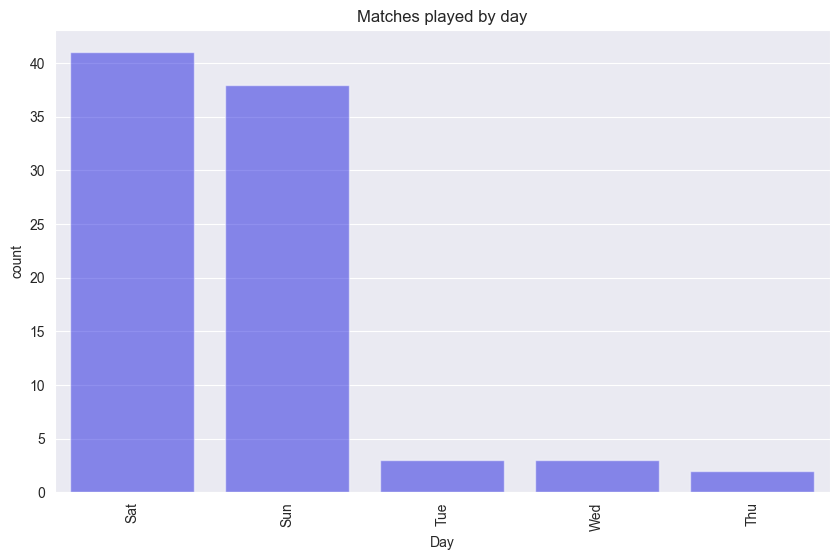

In [7]:
sns.set_style('darkgrid')

# Plot matches by home and away team together
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Matches played by home and away team')
sns.countplot(x='Home', data=matches, color='blue', alpha=0.5)
sns.countplot(x='Away', data=matches, color='red', alpha=0.5)
plt.legend(['Home','Away'])
plt.show()

#------------------------------------------------------------------------

# Plot the days the matches were played
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Matches played by day')
sns.countplot(x='Day', data=matches, color='blue', alpha=0.5)
plt.show()


,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway
40,7,Sat,2022-10-29,12:00,Madrid CFF,1.9,2–0,0.2,UDG Tenerife,2.56,0.27,2,0
41,7,Sat,2022-10-29,16:00,Alavés,0.4,1–5,2.2,Real Sociedad,0.32,2.52,1,5
8,3,Sat,2022-09-24,12:00,Madrid CFF,3.4,3–1,0.5,Levante Planas,2.78,0.15,3,1
83,11,Sun,2022-12-04,12:00,Valencia,0.4,0–1,1.7,Atlético Madrid,0.47,2.31,0,1
62,8,Sun,2022-11-06,18:00,Real Madrid,0.4,0–4,3.4,Barcelona,0.12,2.82,0,4


[2023-11-01T23:34:20.196+0100] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2023-11-01T23:34:20.207+0100] {category.py:223} INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


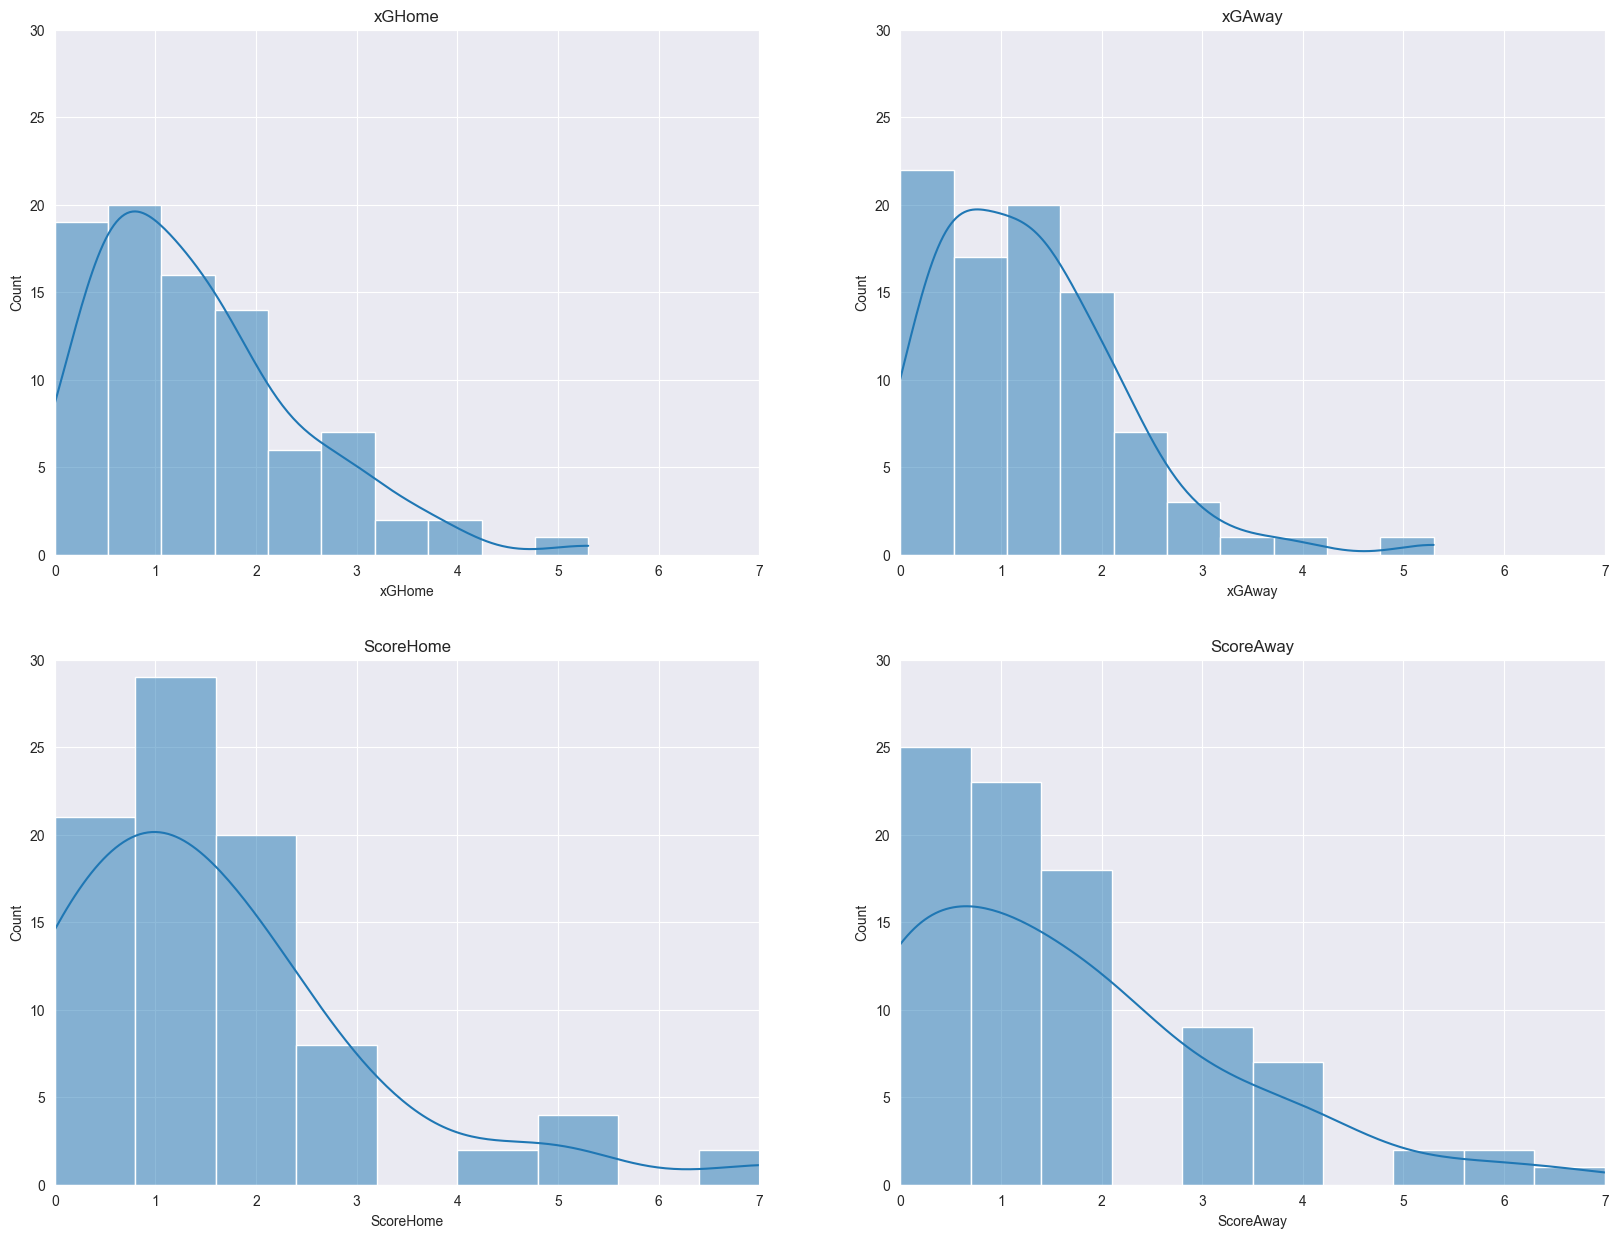

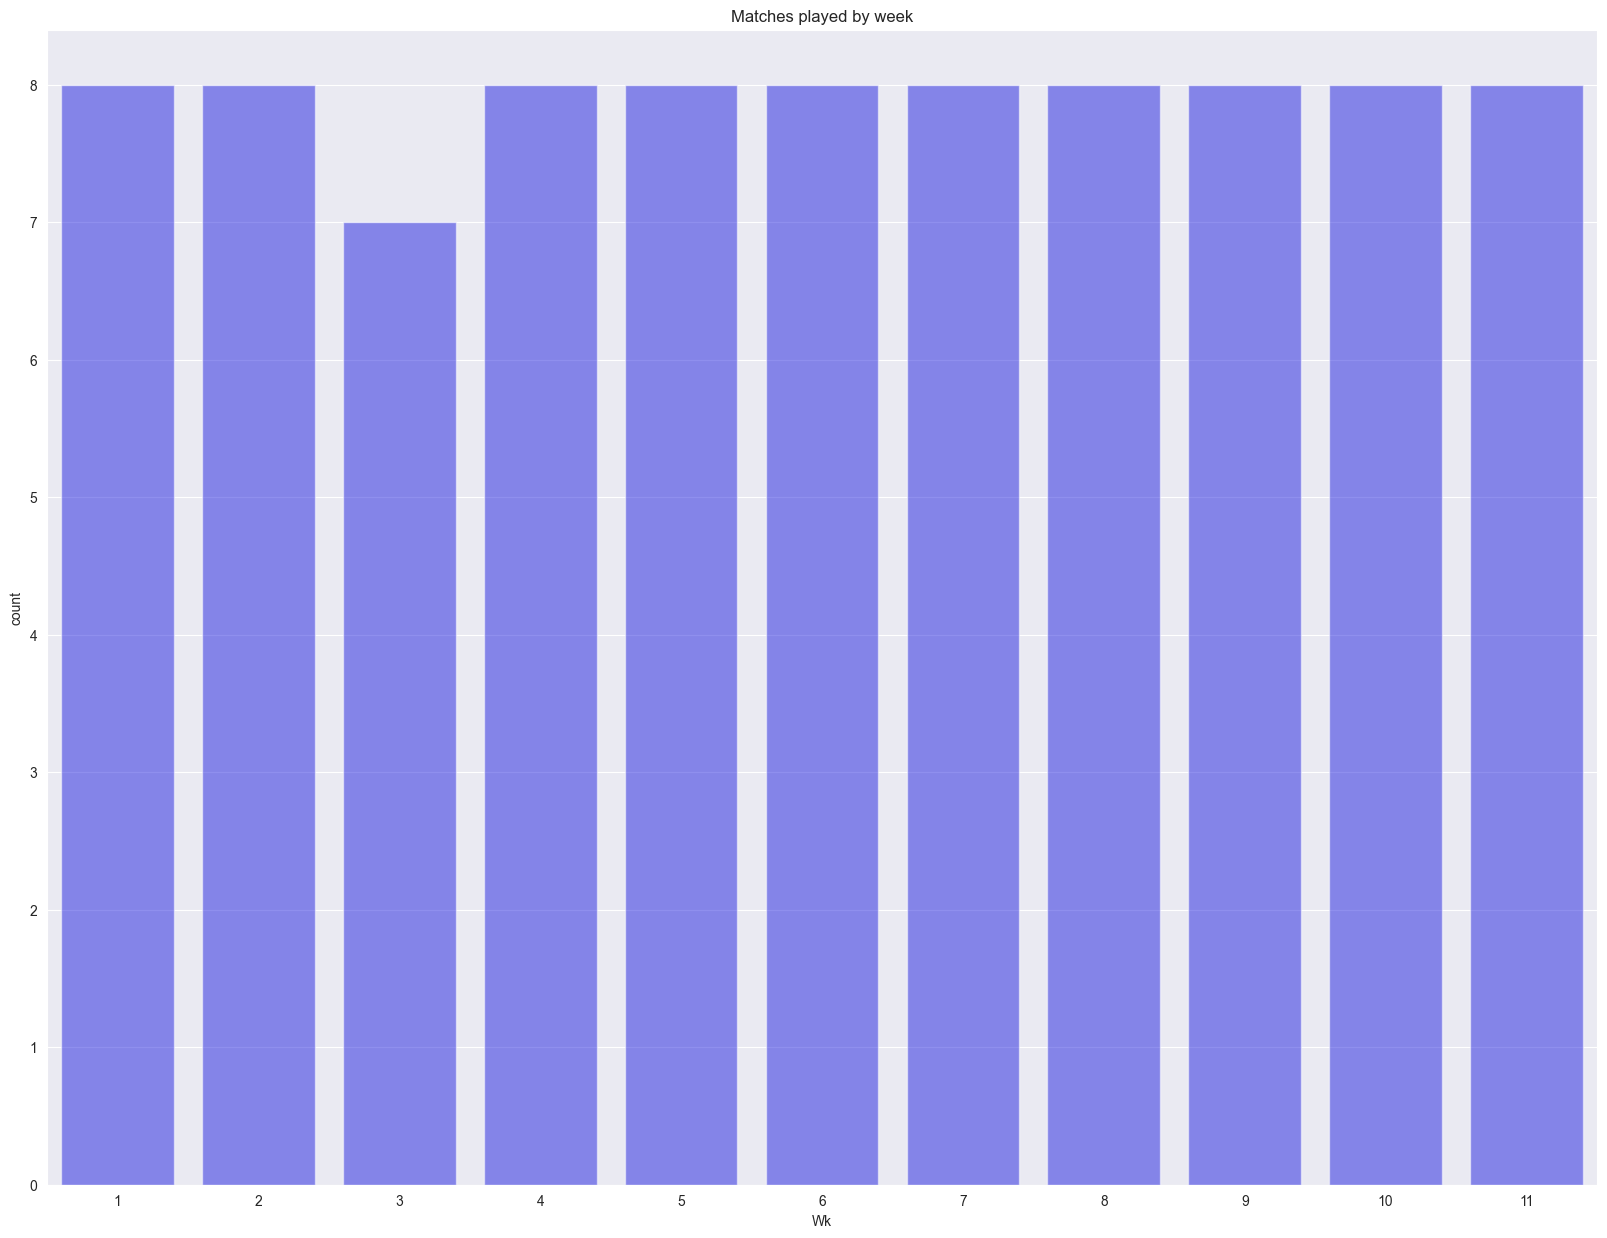

In [8]:
# Check the interger columns
integer_columns = matches.select_dtypes(include=['int64', 'float64']).columns
integer_columns = integer_columns.drop(['xPAway', 'xPHome'])

display(matches.sample(5))
# Check distribution of the integer columns
plt.figure(figsize=(20,15))

for i, col in enumerate(integer_columns[1:]):
    plt.subplot(2,2,i+1)
    plt.ylim(0, 30)
    plt.xlim(0, 7)
    sns.histplot(matches[col], stat='count', kde=True, bins=10)
    plt.title(col)

# Plot the value counts of the Wk column
plt.figure(figsize=(20,15))
plt.title('Matches played by week')
sns.countplot(x='Wk', data=matches, color='blue', alpha=0.5)
plt.show()

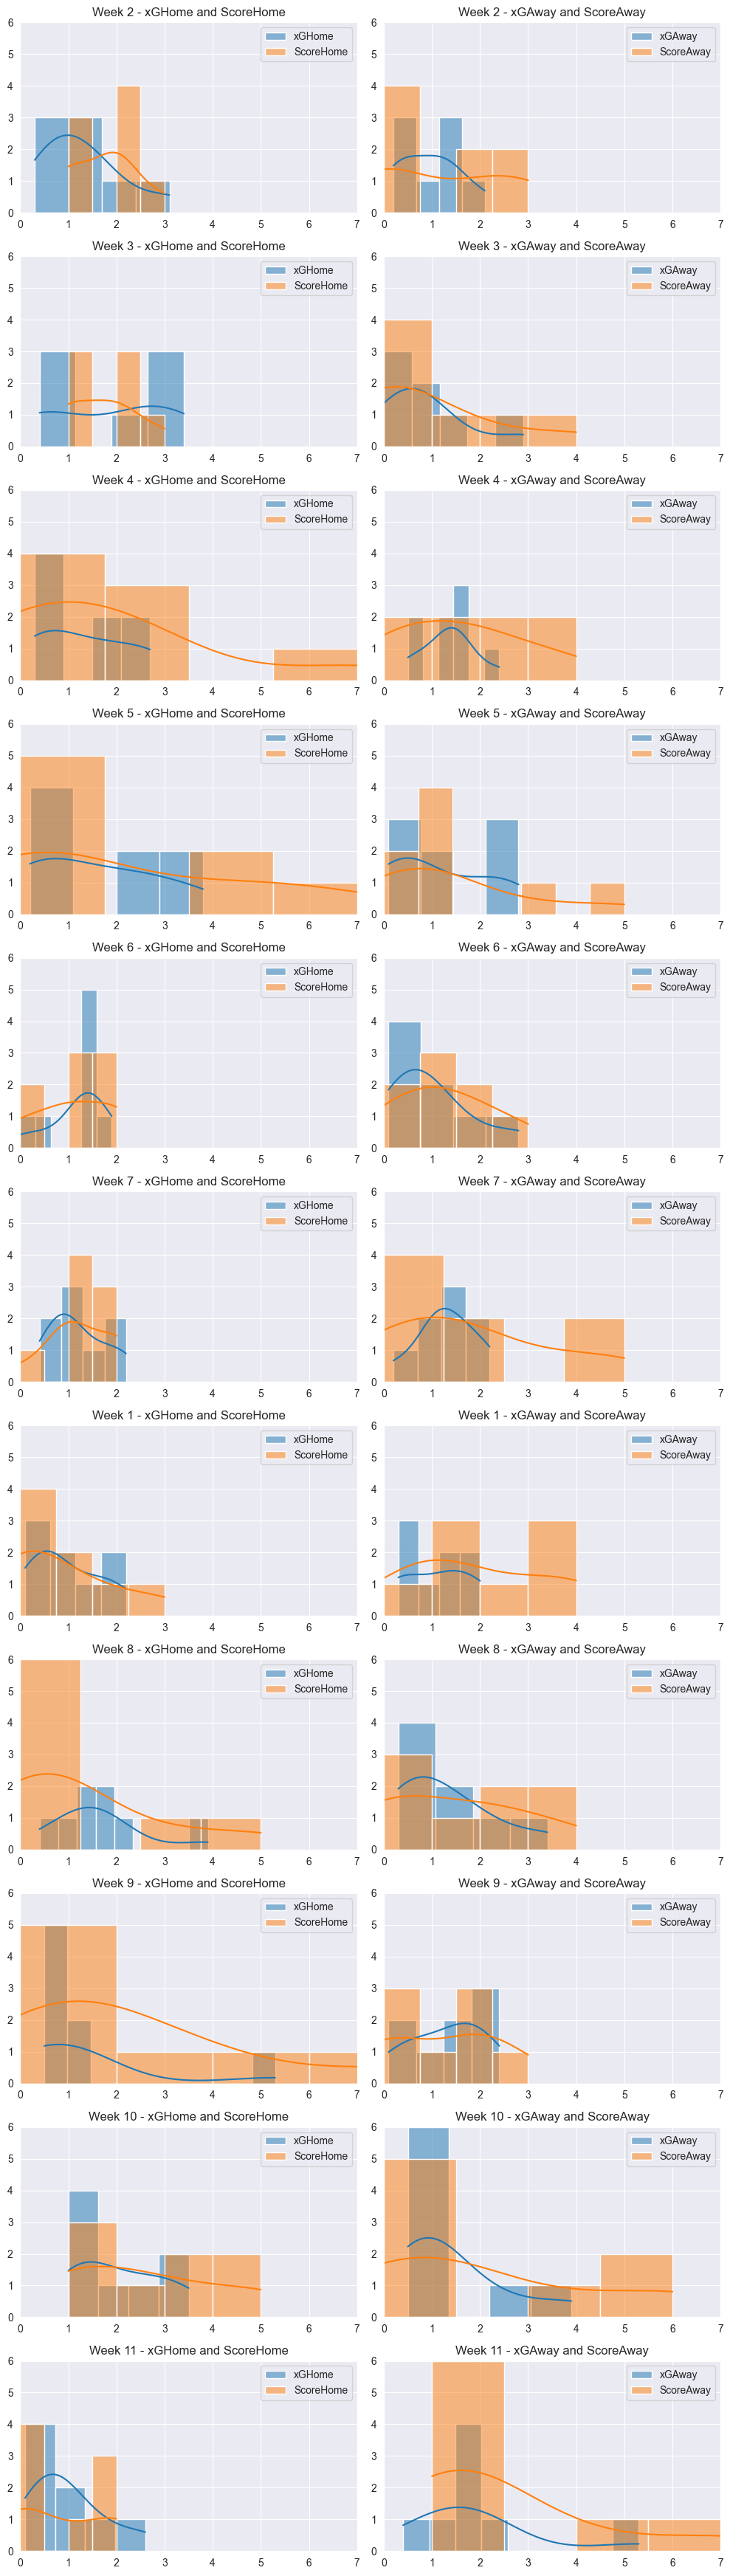

In [9]:
# Group the data by week and get the distributions of the integer columns
plt.figure(figsize=(10, 35))

integer_columns = ['xGHome', 'ScoreHome', 'xGAway', 'ScoreAway']
weeks = matches['Wk'].unique()
num_weeks = len(weeks)
num_cols = len(integer_columns) // 2

for i, week in enumerate(weeks):
    plt.subplot(num_weeks, num_cols, i*num_cols+1)
    plt.ylim(0, 6)
    plt.xlim(0, 7)
    for col in integer_columns[:2]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week} - xGHome and ScoreHome')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

    plt.subplot(num_weeks, num_cols, i*num_cols+2)
    plt.ylim(0, 6)
    plt.xlim(0, 7)
    for col in integer_columns[2:]:
        sns.histplot(matches[matches['Wk'] == week][col], stat='count', kde=True, label=col)
    plt.title(f'Week {week} - xGAway and ScoreAway')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend()

plt.tight_layout()
plt.show()


<Figure size 3000x3500 with 0 Axes>

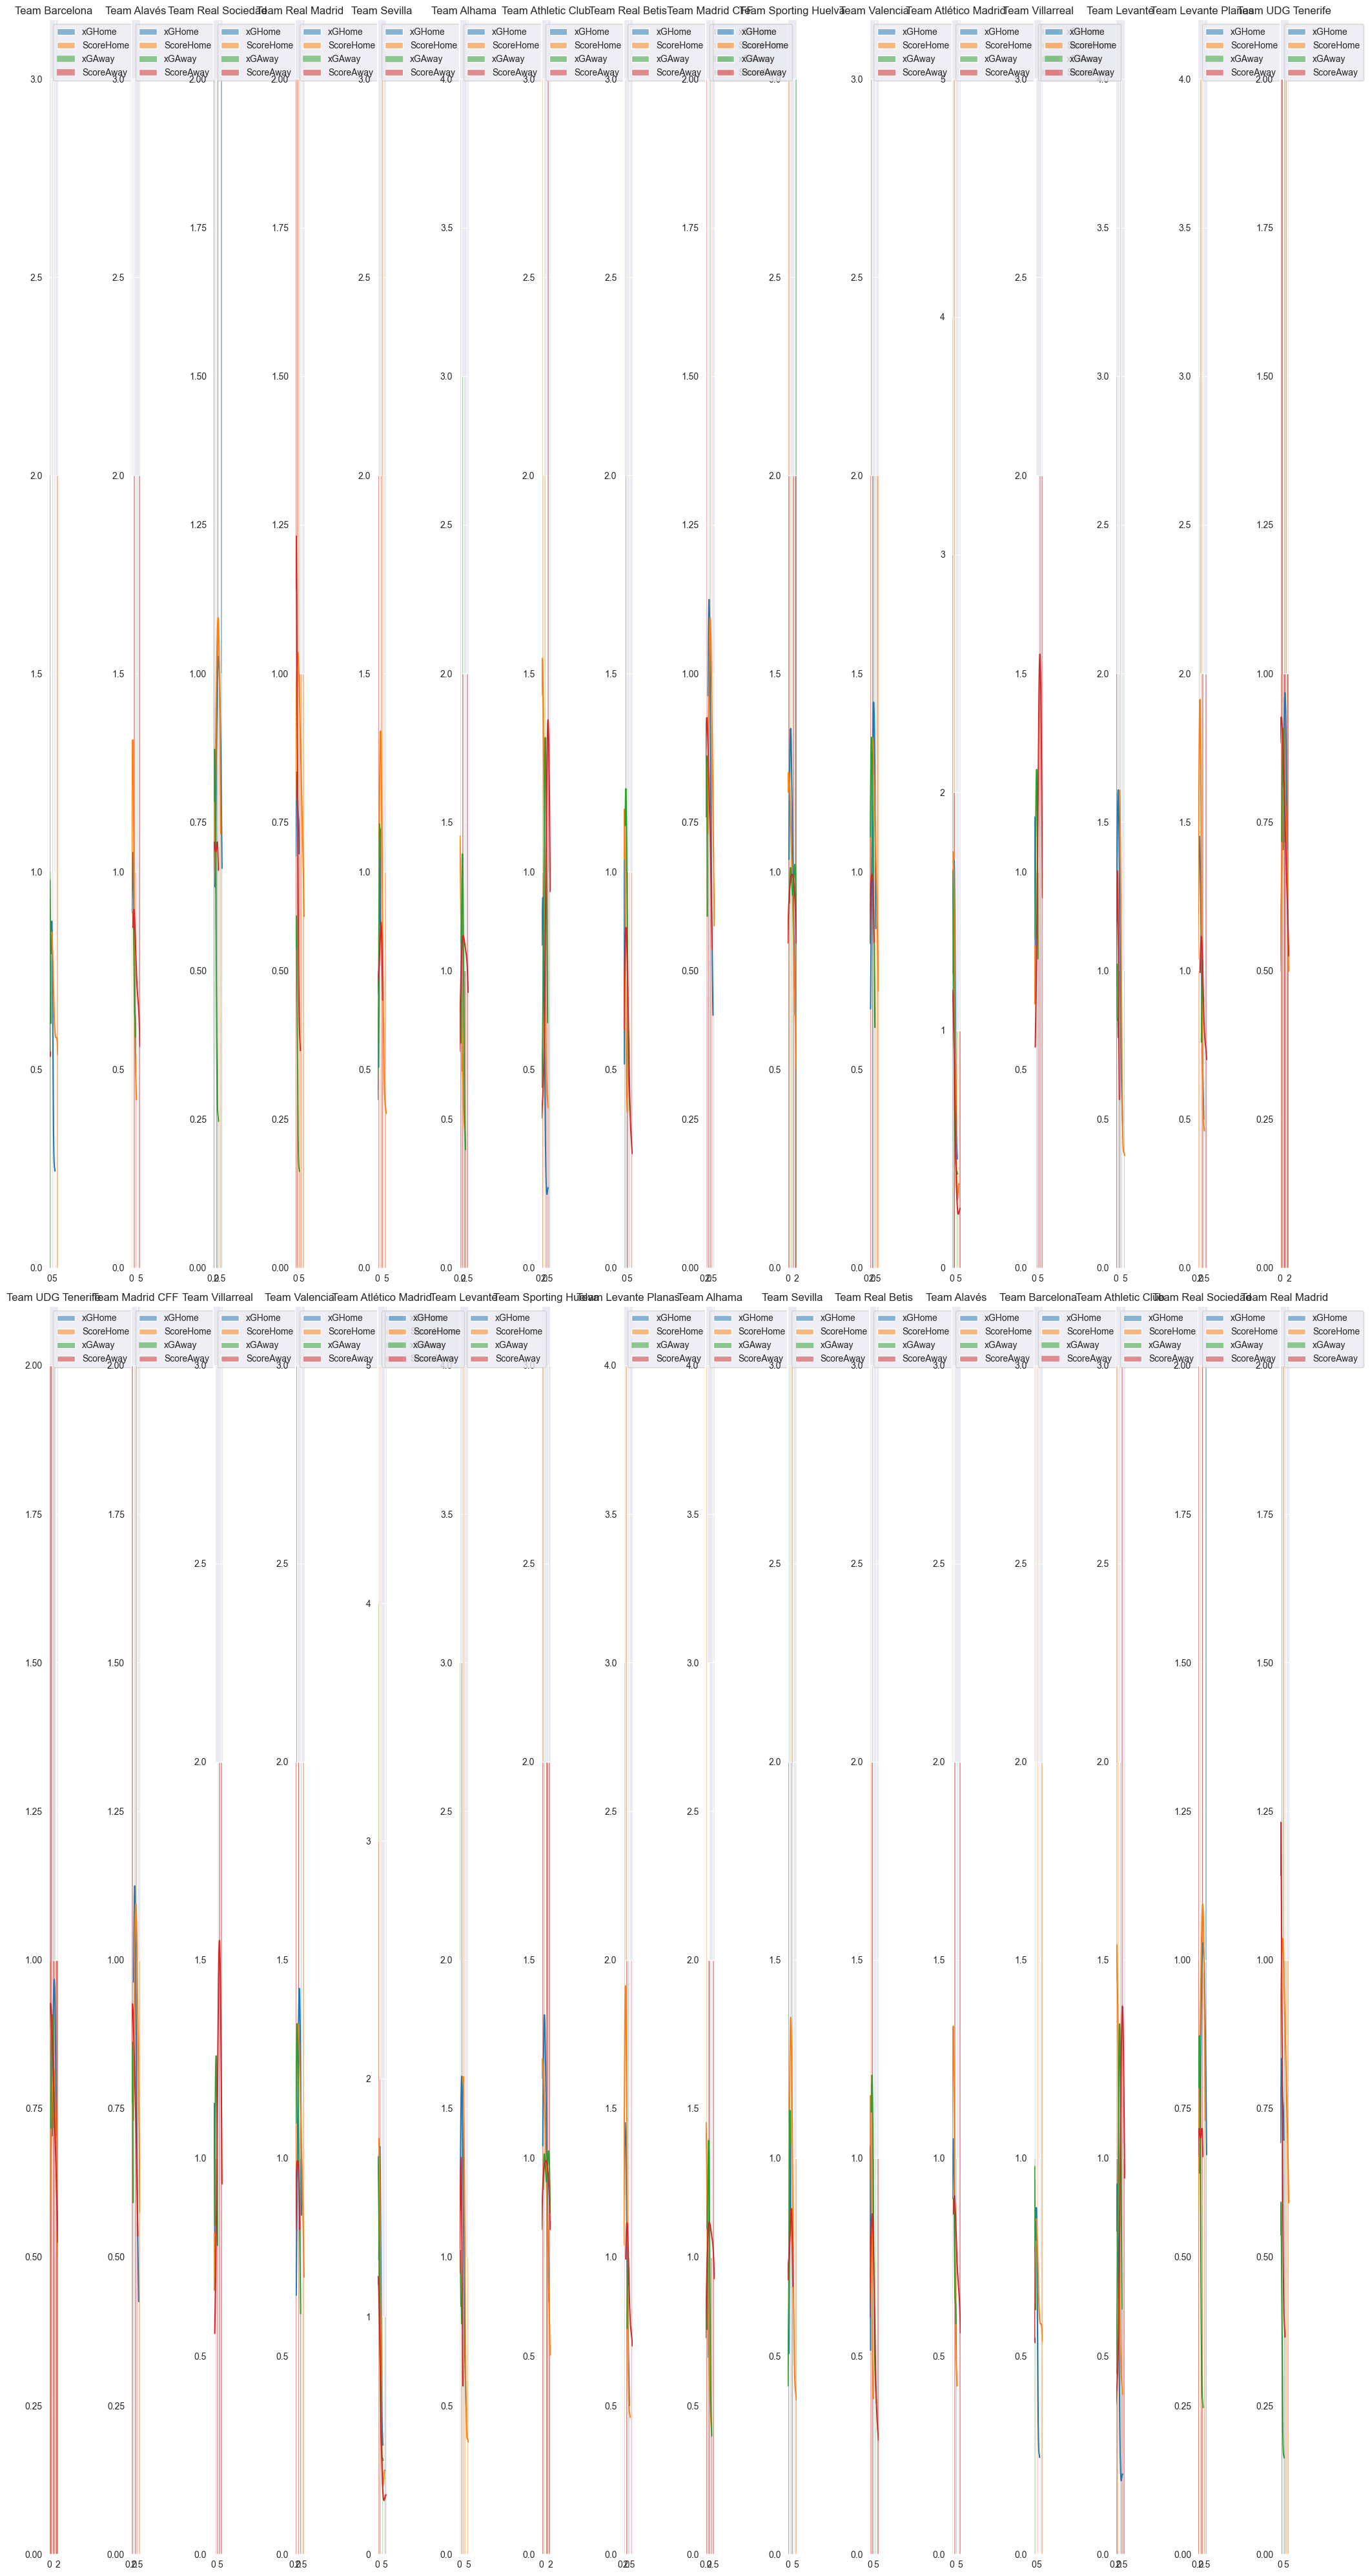

In [97]:
plt.figure(figsize=(30, 35))

integer_columns = ['xGHome', 'ScoreHome', 'xGAway', 'ScoreAway']
# teams = matches['Wk'].unique()
teams = np.concatenate((matches['Home'].unique(), matches['Away'].unique()))
num_teams = len(teams)
num_cols = num_teams // 2

fig, axes = plt.subplots(2, num_cols, figsize=(20, 40))

for i, team in enumerate(teams):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    for col in integer_columns:
        sns.histplot(matches[matches['Home'] == team][col], stat='count', kde=True, label=col, ax=ax)
    
    ax.set_title(f'Team {team}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.legend()

plt.tight_layout()
plt.show()


Index(['Day', 'Home', 'Away'], dtype='object')


,Wk,Day,Date,Time,Home,xGHome,Score,xGAway,Away,xPHome,xPAway,ScoreHome,ScoreAway,Numeric_Day
47,1,Tue,2022-11-01,16:00,Atlético Madrid,1.5,1–1,1.4,Real Sociedad,1.43,1.31,1,1,2
20,4,Sun,2022-10-02,12:00,Levante,0.9,2–1,1.3,Atlético Madrid,1.06,1.65,2,1,7
17,4,Sat,2022-10-01,16:00,Sporting Huelva,0.3,0–0,0.5,Valencia,1.03,1.45,0,0,6
38,6,Sun,2022-10-23,18:00,Sevilla,1.5,2–0,0.1,Alhama,2.46,0.30,2,0,7
10,3,Sat,2022-09-24,16:00,Valencia,2.8,2–0,1.3,Sevilla,2.22,0.62,2,0,6


,Wk,xGHome,xGAway,ScoreHome,ScoreAway,Numeric_Day
Wk,1.000000,0.063059,0.230310,0.061402,0.129222,0.470651
xGHome,0.063059,1.000000,-0.496339,0.716966,-0.439891,0.097118
xGAway,0.230310,-0.496339,1.000000,-0.410320,0.776751,0.078622
ScoreHome,0.061402,0.716966,-0.410320,1.000000,-0.444516,0.157567
ScoreAway,0.129222,-0.439891,0.776751,-0.444516,1.000000,-0.045121
Numeric_Day,0.470651,0.097118,0.078622,0.157567,-0.045121,1.000000


[1.0, 0.06305925505988365, 0.2303103140616799, 0.06140151737638461, 0.129222244624548, 0.4706513069175167, 0.06305925505988365, 1.0, -0.49633916043136694, 0.7169664926791077, -0.4398908429655143, 0.09711828376781928, 0.2303103140616799, -0.49633916043136694, 1.0, -0.41032017620198397, 0.77675101212862, 0.07862191897678378, 0.06140151737638461, 0.7169664926791077, -0.41032017620198397, 1.0, -0.44451619619598237, 0.15756669887485053, 0.129222244624548, -0.4398908429655143, 0.77675101212862, -0.44451619619598237, 1.0, -0.04512123891104363, 0.4706513069175167, 0.09711828376781928, 0.07862191897678378, 0.15756669887485053, -0.04512123891104363, 1.0]


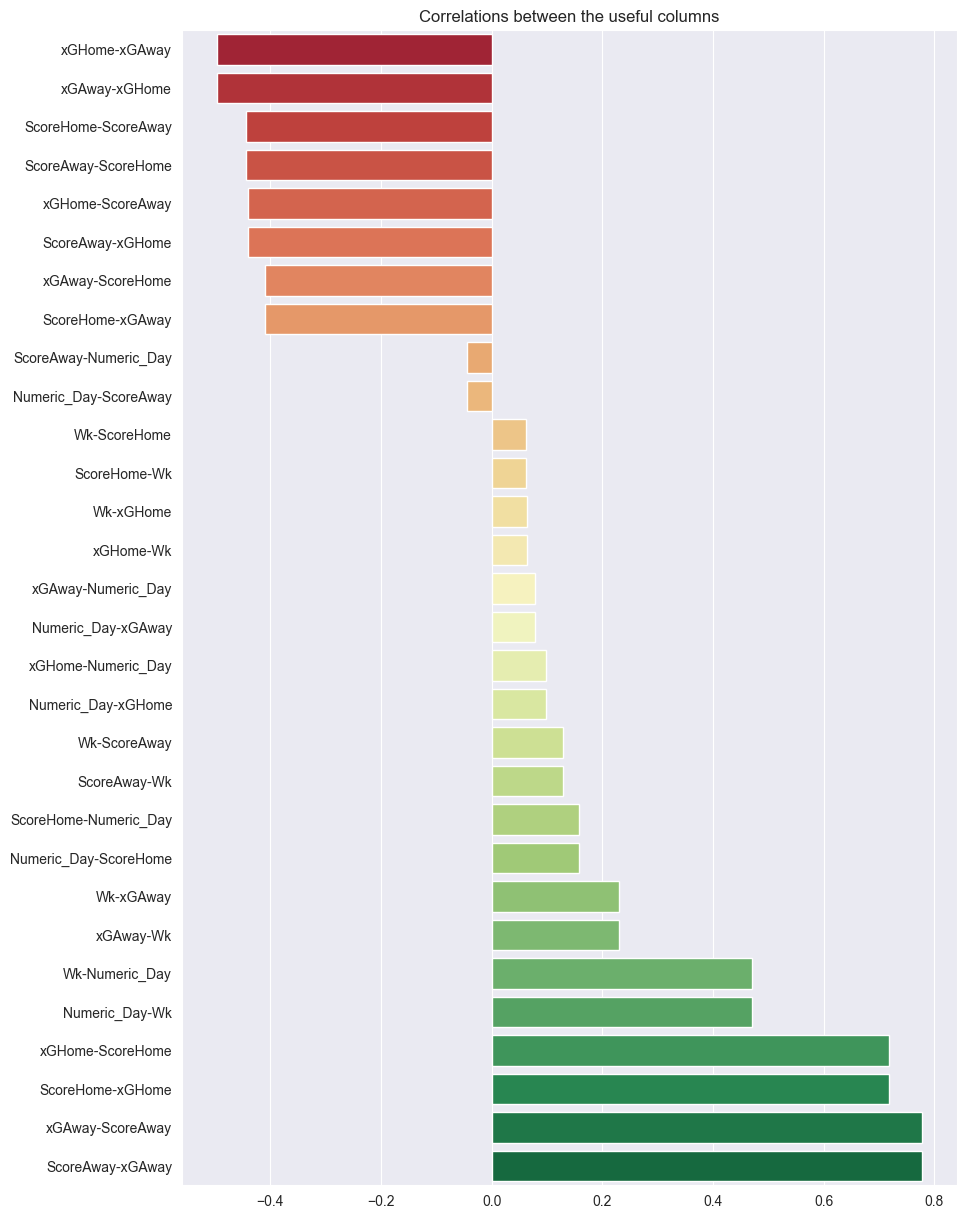

In [79]:
# display(matches.sample(5))
# Encode the categorical columns. The Home and Away columns should match. The Date and Time columns can be ignored.
categorical_columns = matches.select_dtypes(include=['object']).columns
categorical_columns = categorical_columns.drop(['Time', 'Score'])
print(categorical_columns)

"""
!At the moment the Home and Away Columns are not important imo!
# Encode the categorical columns
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

matches['Numeric_Home'] = encoder.fit_transform(matches['Home'])
matches['Numeric_Away'] = encoder.transform(matches['Away']) # Use the same encoder as the Home column"""

# Encode the Day column
matches['Numeric_Day'] = matches['Day'].apply(lambda x: 2 if x == 'Tue' else 3 if x == 'Wed' else 4 if x == 'Thu' else 6 if x == 'Sat' else 7)

display(matches.sample(3))

usefulCols = matches.select_dtypes(include=['int64', 'float64']).columns
usefulCols = usefulCols.drop(['xPAway', 'xPHome'])

# Calculate the correlations between the useful columns
correlations   = matches[usefulCols].corr()
display(correlations)
column_names   = correlations.columns.tolist()
row_names      = correlations.index.tolist()
correspondance = []
correlations_list = []

for col_name in column_names:
    for row_name in row_names:
       value = col_name+'-'+row_name
       correspondance.append(value)

correlations = correlations.unstack().tolist()
for idx, value in enumerate(correspondance):
    correlations_list.append([value, correlations[idx]])

# Plot the correlations as a bar chart using TwoSlopeNorm
from matplotlib.colors import TwoSlopeNorm

# Extract the labels and values from the list of lists
labels = [item[0] for item in correlations_list]
values = [item[1] for item in correlations_list]
print(values)

# Remove the diagonal values
labels = [label for label in labels if label.split('-')[0] != label.split('-')[1]]
values = [value for value in values if value != 1.0]
sorted_labels, sorted_values = zip(*sorted(zip(labels, values), key=lambda x: x[1]))

plt.figure(figsize=(10, 15))
plt.title('Correlations between the useful columns')
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
colors = [plt.cm.RdYlGn(norm(c)) for c in sorted_values]

# Create the barplot using seaborn
sns.barplot(y=labels, x=values, palette=sns.color_palette("RdYlGn", len(sorted_labels)), order=sorted_labels)
plt.ylabel('')
plt.xlabel('')
plt.show()

In [72]:
matches.columns.str.lower()

Index(['wk', 'day', 'date', 'time', 'home', 'xghome', 'score', 'xgaway',
       'away', 'xphome', 'xpaway', 'scorehome', 'scoreaway', 'numeric_day'],
      dtype='object')

## Data Transformation

**Feature Engineering** : Calculate derived metrics

**Data Aggregation** : Aggregate the data to a higher level of granularity.

**Data Filtering** : Filter the dataframe based on specific conditions or criteria. 

**Data Transformation** : Apply mathematical or statistical transformations to the data. 

**Feature Scaling** : Scale the numeric features to a common range to avoid bias in the analysis.

**Data Encoding** : Encode categorical variables into numerical representations. 

In [ ]:
# Transform task
def transform_data(matches):
    # Clean data
    matches = matches.dropna()

    # Convert data types
    matches['Date'] = pd.to_datetime(matches['Date'])
    matches['Time'] = pd.to_datetime(matches['Time'], format='%H:%M').dt.time

    # Goal Difference: You can calculate the goal difference by subtracting the "ScoreAway" from the "ScoreHome" column. This metric gives you the difference in goals scored between the home and away teams in each match.
    matches['GoalDifference'] = matches['ScoreHome'] - matches['ScoreAway']
    
    # Result: You can calculate the result of each match by comparing the "ScoreHome" and "ScoreAway" columns. If the home team scored more goals than the away team, then the home team won the match. If the home team scored fewer goals than the away team, then the home team lost the match. If both teams scored the same number of goals, then the match was a draw.
    matches['Result'] = matches['Score'].apply(lambda x: 'Win' if x[0] > x[2] else 'Draw' if x[0] == x[2] else 'Loss')
    
    # Expected Goals Difference: Similar to the goal difference, you can calculate the expected goals difference by subtracting the "xGAway" from the "xGHome" column. This metric represents the difference in expected goals between the home and away teams in each match.
    matches['ExpectedGoalDifference'] = matches['xGHome'] - matches['xGAway']
    
    # Points: You can calculate the points earned by each team using a scoring system (e.g., 3 points for a win, 1 point for a draw, and 0 points for a loss). You can create a new column called "Points" and assign the corresponding points based on the match result in the "Score" column.
    matches['Points'] = matches['Score'].apply(lambda x: 3 if x[0] > x[2] else 1 if x[0] == x[2] else 0)
    
    # Expected Points: Similar to the points metric, you can calculate the expected points earned by each team using a similar scoring system but based on the expected goals (e.g., 3 points for xGHome > xGAway, 1 point for xGHome = xGAway, and 0 points for xGHome < xGAway). You can create a new column called "ExpectedPoints" and assign the corresponding expected points based on the expected goals in the "xGHome" and "xGAway" columns.
    matches['ExpectedPoints'] = matches['Score'].apply(lambda x: 3 if x[0] > x[2] else 1 if x[0] == x[2] else 0)
    
    # Win Percentage: You can calculate the win percentage for each team by dividing the number of wins (based on the "Score" column) by the total number of matches played.
    wins = matches[matches['Result'] == 'Win'].groupby('Home').size()
    total_matches = matches.groupby('Home').size()
    win_percentage = (wins / total_matches) * 100
    # Add win percentage to matches dataframe
    matches['WinPercentage'] = matches['Home'].map(win_percentage)

    matches['TotalGoals'] = matches['ScoreHome'] + matches['ScoreAway']

    matches['xGRatio'] = matches['xGHome'] / (matches['xGHome'] + matches['xGAway'])

    def get_points(row):
        if row['Result'] == 'Win':
            return 3
        elif row['Result'] == 'Draw':
            return 1
        else:
            return 0
    matches['Points'] = matches.apply(get_points, axis=1)

    return matches

# matches = transform_data(matches)
# display(matches.sample(5), matches.shape)

### ETL Process and Data Integration
_Loading of the data_ . 
__Apache Airflow__ supports a few databases: 
- SQLite _Lightweight filebased database suitable for small-scale deployments and testing_
- PostgreSQL _Relational database widely used in production environments_
- MySQL _Popular relational database widely used_
- Microsoft SQL Server _Commercial relational database widely used in enterprises_
- Oracle _Commercial relational database widely used in enterprises_
- Amazon RedShift _Cloud-based data warehouse optimized for analytics workloads_
- Google BigQuery _Cloud-based data warehouse optimized for analytics workloads_
- Apache Casssandra _Distributed No-SQL database optimized for high scalability and availability_
- Apache Hive _Data warehouse infrastructure for data summarization, querying and analytics_

I'm using SQLite because it's a small scale dataset

In [ ]:
# Load task
def load_data(matches):
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Create table
    c.execute("""CREATE TABLE IF NOT EXISTS matches (
        Wk INTERGER,
        Day TEXT,
        Date DATE,
        Time TIME,
        Home TEXT,
        xGHome FLOAT,
        Score TEXT,
        xGAway FLOAT,
        Away TEXT,
        xPHome FLOAT,
        xPAway FLOAT,
        ScoreHome INTERGER,
        ScoreAway INTERGER,
        GoalDifference INTERGER,
        Result TEXT,
        ExpectedGoalDifference FLOAT,
        Points INTERGER,
        ExpectedPoints INTERGER,
        WinPercentage FLOAT,
        TotalGoals INTERGER,
        xGRatio FLOAT
    )""")

    # Insert DataFrame records one by one.
    for i, row in matches.iterrows():
        c.execute("""INSERT INTO matches VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)""", (
            row['Wk'],
            row['Day'],
            row['Date'],
            row['Time'],
            row['Home'],
            row['xGHome'],
            row['Score'],
            row['xGAway'],
            row['Away'],
            row['xPHome'],
            row['xPAway'],
            row['ScoreHome'],
            row['ScoreAway'],
            row['GoalDifference'],
            row['Result'],
            row['ExpectedGoalDifference'],
            row['Points'],
            row['ExpectedPoints'],
            row['WinPercentage'],
            row['TotalGoals'],
            row['xGRatio']
        ))

    # Commit changes
    conn.commit()

    # Close cursor and connection
    c.close()
    conn.close()


In [ ]:
# Assign tasks
extract_task = PythonOperator(
    task_id='extract_data',
    python_callable=extract_data,
    dag=dag
)

transform_task = PythonOperator(
    task_id='transform_data',
    python_callable=transform_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="extract_data") }}'},
    dag=dag
)

load_task = PythonOperator(
    task_id='load_data',
    python_callable=load_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="transform_data") }}'},
    dag=dag
)

In [ ]:
!~/airflow_env/bin/airflow scheduler -D
!~/airflow_env/bin/airflow webserver -D

!~/airflow_env/bin/airflow dags list

!~/airflow_env/bin/airflow cheat-sheet

## Validation and Quality Assurance

To validate the quality of the data, I'm connecting to the database to check for null values in each column of the matches table.  
Specifically, I'll check the data type, the range anf completeness of the data

In [ ]:
# Validate data in the database and ensure the proper quality
def validate_data():
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Data type validation
    c.execute("""SELECT COUNT(*) FROM matches where CAST(Wk AS INTEGER) IS NULL""")
    null_count = c.fetchone()[0]
    if null_count == 0:
        print('Data type validation passed.')
    else:
        print(f'Data type validation failed with {null_count} null values.')

    # Data range validation
    c.execute("""SELECT COUNT(*) FROM matches where Wk < 1 OR Wk > 10""")
    range_count = c.fetchone()[0]
    if range_count == 0:
        print('Data range validation passed.')
    else:
        print(f'Data range validation failed with {range_count} values out of range.')

    # Data completeness validation
    c.execute("""SELECT COUNT(*) FROM matches where Wk IS NULL""")
    completeness_count = c.fetchone()[0]
    if completeness_count == 0:
        print('Data completeness validation passed.')
    else:
        print(f'Data completeness validation failed with {completeness_count} null values.')

    c.close()
    conn.close()

validate_task = PythonOperator(
    task_id='validate_data',
    python_callable=validate_data,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="load_data") }}'},
    dag=dag
)

# Define task dependencies
extract_task >> transform_task >> load_task >> validate_task

## Reporting and Analysis

Generate meaningful insights and reports.
- Trend analysis
- Team Performance analysis
- Team comparisons

In [ ]:
# Trend analysis
def trend_analysis():
    # Connect to database
    conn = sqlite3.connect('assets/spanish_matches.db')

    # Create cursor
    c = conn.cursor()

    # Data type validation
    c.execute("""SELECT * FROM matches""")
    matches = pd.DataFrame(c.fetchall())
    
    # Define plot function
    def plot_data():
        sns.lineplot(x='Date', y='TotlaGoals', data=matches)
        plt.title('Total Goals Scored')
        plt.xlabel('Date')
        plt.ylabel('Total Goals')
        plt.show()
    # Look at the correlation between the expected goals and the actual goals
    def calculate_correlation():
        corr_home = matches['xGHome'].corr(matches['ScoreHome'])
        print(f'Correlation between expected Goals for the Home and actual goals Home: {corr_home}')
        corr_away = matches['xGAway'].corr(matches['ScoreAway'])
        print(f'Correlation between expected Goals for the Away and actual goals Away: {corr_away}')
    
    plot_data()
    calculate_correlation()

trend_analysis_task = PythonOperator(
    task_id='trend_analysis',
    python_callable=trend_analysis,
    op_kwargs={'matches': '{{ ti.xcom_pull(task_ids="validate_data") }}'},
    dag=dag
)   

# Define task dependencies
extract_task >> transform_task >> load_task >> validate_task >> trend_analysis_task

In [ ]:
# Exectute the DAG workflow and view the results in the Airflow UI from scripts/DataPipelining.py
!~/airflow_env/bin/airflow trigger_dag 

In [ ]:
# Convert notebook to python script
!jupyter nbconvert --to script DataPipelining.ipynb --output-dir='airflow/dags/'